In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, BayesianRidge, HuberRegressor, SGDRegressor, LogisticRegression
from itertools import combinations

In [2]:
data = pd.read_csv('winequality-red.csv', sep=";")

In [3]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [4]:
quantile_sulphates = data['sulphates'].quantile(q = 0.96)
data = data[~(data['sulphates']>quantile_sulphates)]
quantile_sulfur_dioxide = data['total sulfur dioxide'].quantile(q = 0.90)
data = data[~(data['total sulfur dioxide']>quantile_sulfur_dioxide)]
#quantile_fixed_acity = data['fixed acidity'].quantile(q = 0.99)
#data = data[~(data['fixed acidity']>quantile_fixed_acity)]
data = data.drop('residual sugar', axis=1)
data = data.drop('chlorides', axis=1)

In [5]:
data.describe()

,fixed acidity,volatile acidity,citric acid,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,8.344501,0.525543,0.261302,14.564761,37.929088,0.996702,3.323249,0.639906,10.491184,5.680174
std,1.791967,0.180415,0.195820,9.441633,21.529068,0.001863,0.151123,0.120311,1.064580,0.817370
min,4.600000,0.120000,0.000000,1.000000,6.000000,0.990200,2.860000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.080000,7.000000,20.000000,0.995510,3.220000,0.550000,9.600000,5.000000
50%,7.900000,0.515000,0.240000,12.000000,34.000000,0.996675,3.320000,0.620000,10.300000,6.000000
75%,9.300000,0.640000,0.420000,19.000000,52.000000,0.997800,3.410000,0.720000,11.200000,6.000000
max,15.900000,1.580000,0.790000,54.000000,91.000000,1.003200,4.010000,0.970000,14.900000,8.000000


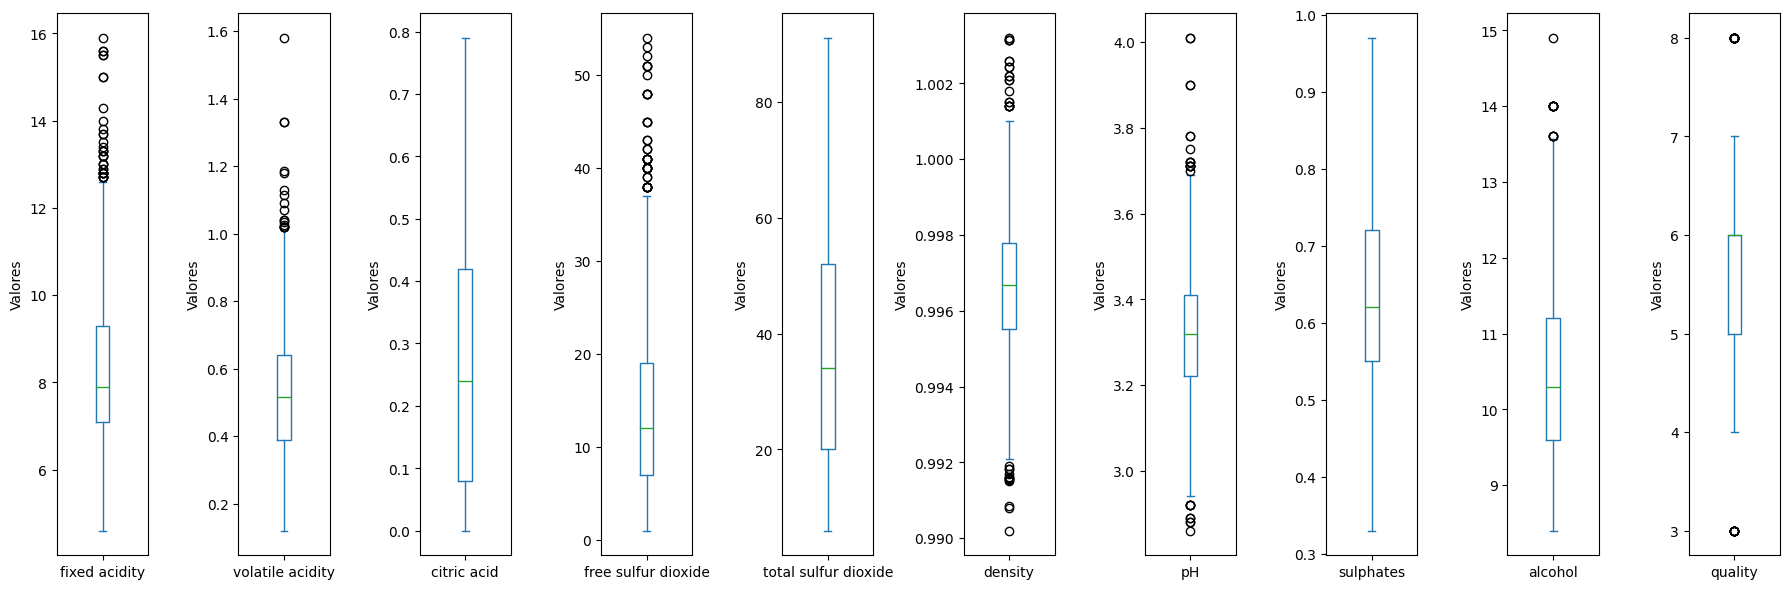

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=len(data.columns), figsize=(18, 6))
for i, column in enumerate(data.columns):
    data[column].plot(kind='box', ax=axs[i], fontsize=10)
    axs[i].set_ylabel('Valores', fontsize=10)
plt.tight_layout()
plt.show()

In [7]:
y = data['quality']
X = data.drop('quality', axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

In [9]:
scalar = StandardScaler()
scalar.fit(X_train)
X_train = pd.DataFrame(scalar.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scalar.transform(X_test), index=X_test.index, columns=X_test.columns)

In [10]:
models = {
    "Ridge": Ridge(),
    "BayesianRidge": BayesianRidge(),
    "HuberRegressor": HuberRegressor(),
    "SGDRegressor": SGDRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "LogisticRegression": LogisticRegression()
}

In [11]:
model_results = {}
for model_name, model in models.items():
    reg_pipeline = Pipeline([
        ("scalar", StandardScaler()),
        ("numerical_imputer", SimpleImputer(strategy='mean')),
        ("model", model)])
    reg_pipeline.fit(X_train, y_train)
    model_results[model_name] = reg_pipeline

In [12]:
test_scores = {}
for model_name, model in model_results.items():
    y_pred = model.predict(X_test)
    test_scores[model_name] = r2_score(y_test, y_pred)
    results = pd.DataFrame(list(test_scores.items()), columns=['Modelo', 'Puntaje R^2'])
    results.set_index('Modelo', inplace=True)
results

,Puntaje R^2
Modelo,
Ridge,0.307918
BayesianRidge,0.309615
HuberRegressor,0.311731
SGDRegressor,0.300316
RandomForestRegressor,0.519301
LogisticRegression,0.136913


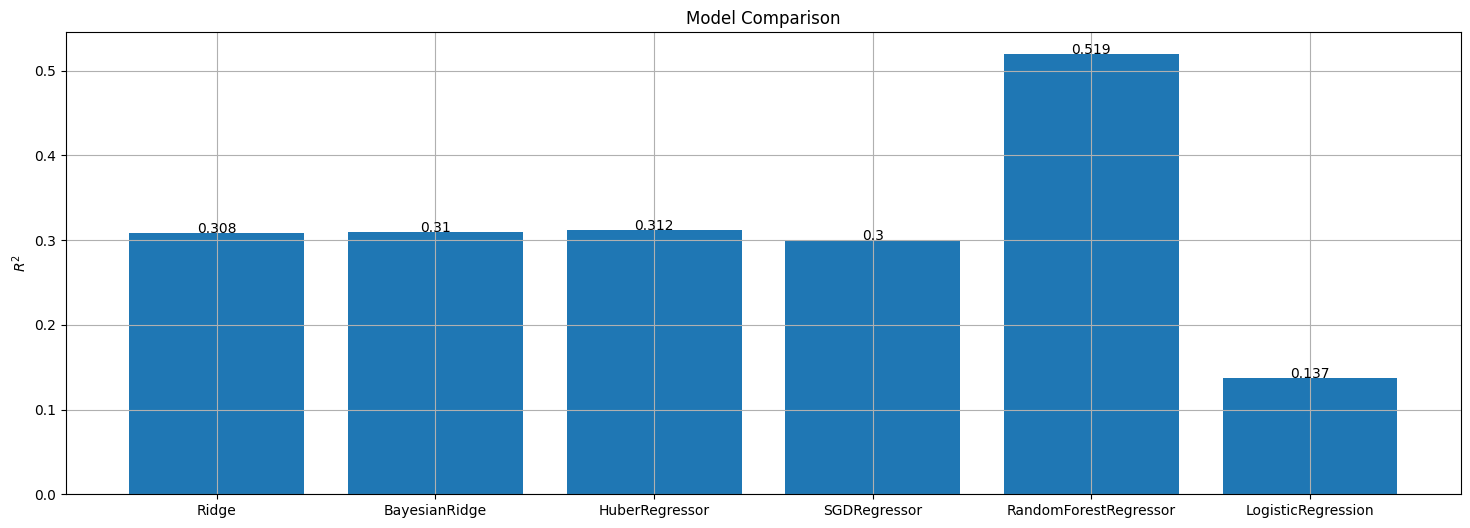

In [13]:
plt.figure(figsize=(18, 6))
bars = plt.bar(test_scores.keys(), test_scores.values())
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center')
plt.ylabel('$R^2$')
plt.title('Model Comparison')
plt.grid()
plt.show()

In [14]:
data = pd.read_csv('winequality-red.csv', sep=";")

y = data['quality']
X = data.drop('quality', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

scalar = StandardScaler()
scalar.fit(X_train)
X_train = pd.DataFrame(scalar.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scalar.transform(X_test), index=X_test.index, columns=X_test.columns)

models = {
    "RandomForestRegressor": RandomForestRegressor(),
}

all_combinations = []
for i in range(1, len(X_train.columns) + 1):
    all_combinations += list(combinations(X_train.columns, i))

model_results = {}
for combination in all_combinations:
    combination_name = ', '.join(combination)
    X_train_subset = X_train[list(combination)]
    X_test_subset = X_test[list(combination)]
    model_results[combination_name] = {}
    for model_name, model in models.items():
        reg_pipeline = Pipeline([
            ("numerical_imputer", SimpleImputer(strategy='mean')),
            ("model", model)
        ])
        reg_pipeline.fit(X_train_subset, y_train)
        y_pred = reg_pipeline.predict(X_test_subset)
        test_score = r2_score(y_test, y_pred)
        model_results[combination_name][model_name] = test_score
results = pd.DataFrame(model_results)
results.index.name = 'Modelo'
results.columns.name = 'Combinación de Características'
results = results.stack().reset_index()
results.columns = ['Modelo', 'Combinación de Características', 'Puntaje R^2']
results.sort_values('Puntaje R^2', ascending=False).head(15)

,Modelo,Combinación de Características,Puntaje R^2
1553,RandomForestRegressor,"fixed acidity, volatile acidity, citric acid, ...",0.463548
1545,RandomForestRegressor,"fixed acidity, volatile acidity, citric acid, ...",0.455008
1147,RandomForestRegressor,"fixed acidity, volatile acidity, total sulfur ...",0.454382
1868,RandomForestRegressor,"fixed acidity, volatile acidity, citric acid, ...",0.454324
1548,RandomForestRegressor,"fixed acidity, volatile acidity, citric acid, ...",0.452009
1869,RandomForestRegressor,"fixed acidity, volatile acidity, citric acid, ...",0.451044
2003,RandomForestRegressor,"fixed acidity, volatile acidity, citric acid, ...",0.447952
1962,RandomForestRegressor,"volatile acidity, citric acid, free sulfur dio...",0.447639
1847,RandomForestRegressor,"fixed acidity, volatile acidity, citric acid, ...",0.447446
1985,RandomForestRegressor,"fixed acidity, volatile acidity, citric acid, ...",0.447030


In [15]:
repetidas = results.sort_values('Puntaje R^2', ascending=False)
df_split = repetidas['Combinación de Características'].str.split(',', expand=True).head(200)

In [16]:
new_df = pd.DataFrame()
dfs = pd.DataFrame()
for i in  df_split.columns:
  dfs['nombre'] = df_split[i].value_counts().reset_index()[i]
  dfs['count'] = df_split[i].value_counts().reset_index()['count']
  new_df = pd.concat([new_df, dfs], axis=0)

In [17]:
new_df = new_df.dropna()  
tabla_suma = new_df.groupby('nombre')['count'].sum().reset_index()
tabla_suma.sort_values(by='count', ascending=False).reset_index()[['nombre', 'count']].head(9)['nombre']

0                sulphates
1            fixed acidity
2                  alcohol
3              citric acid
4      free sulfur dioxide
5         volatile acidity
6     total sulfur dioxide
7                  density
8                       pH
Name: nombre, dtype: object